In [8]:
import numpy as np

In [133]:
class Beam:
    def __init__(self, modulus_elasticity = None, moment_inertia = None, length = None, area = None, material_stiffness= None, element_connection = None, nodes = None, elements = None, theta = None, node_status = None, load_status = None):
        self.modulus_elasticity = modulus_elasticity 
        self.moment_inertia = moment_inertia 
        self.length = length 
        self.area = area 
        self.nodes = nodes
        self.element_connection = element_connection
        self.material_stiffness = material_stiffness
        self.elements = elements
        self.stiffness_list = []
        self.global_stiffness_matrix = []        
        self.theta = theta
        self.node_status = node_status
        self.load_status = load_status
        self.dof = len(next(iter(self.node_status.values())))

    def transform_lambda(self, idx):
        theta = self.theta[idx]
        C = np.round(np.cos(np.radians(theta)), 5) 
        S = np.round(np.sin(np.radians(theta)), 5) 
        # print(f'C: {C}')
        # print(f'S: {S}')
        mat = np.array([[ C, S, 0,  0, 0, 0],
                        [-S, C, 0,  0, 0, 0],
                        [ 0, 0, 1,  0, 0, 0],
                        [ 0, 0, 0,  C, S, 0],
                        [ 0, 0, 0, -S, C, 0],
                        [ 0, 0, 0,  0, 0, 1]
                        ])
        return mat
    
    def truncate_stiffness(self, stiffness):
        if (self.dof == 2):
            stiffness = np.delete(np.delete(stiffness, [0,3], axis=0), [0,3], axis=1)
        return stiffness

    def truncate_spring_stiffness(self, stiffness):
        if (self.dof == 2):
            stiffness = np.delete(np.delete(stiffness, [2,5], axis=0), [2,5], axis=1)
        return stiffness    
    
    def element_stiffness_2D(self, idx):

        area = self.area[idx] or 0
        length = self.length[idx]
        moment_inertia = self.moment_inertia[idx]
        
        transform_matrix = self.transform_lambda(idx)
        a_len = area/length
        m_len_3 = moment_inertia/length**3
        m_len_2 = moment_inertia/length**2
        m_len = moment_inertia/length

        stiffness = self.modulus_elasticity[idx] * np.array([[a_len, 0, 0, -a_len, 0, 0], 
                                                             [0, 12*m_len_3, 6*m_len_2, 0, -12*m_len_3, 6*m_len_2],
                                                             [0, 6*m_len_2, 4*m_len, 0, -6*m_len_2, 2*m_len],
                                                             [-a_len, 0, 0, a_len, 0, 0],
                                                             [0, -12*m_len_3, -6*m_len_2, 0, 12*m_len_3, -6*m_len_2],
                                                             [0, 6*m_len_2, 2*m_len, 0, -6*m_len_2, 4*m_len]
                                                            ])
        # print(stiffness)
        # print("transform_matrix.T")
        # print(transform_matrix.T)
        # print("transfrom_matrix")
        # print(transform_matrix)
        transform_stiffness = np.matmul(transform_matrix.T, stiffness)
        transform_stiffness = np.matmul(transform_stiffness, transform_matrix)

        transform_stiffness = self.truncate_stiffness(transform_stiffness)
        return transform_stiffness

    def spring_element_stiffness_2D(self,idx):
        K = self.material_stiffness[idx]
        C = np.round(np.cos(np.radians(self.theta[idx])), 5) 
        S = np.round(np.sin(np.radians(self.theta[idx])), 5) 
        
        # print(f'C: {C}')
        # print(f'S: {S}')
        stiffness = K*np.array([[C*C, C*S, 0,-C*C, -C*S,0],
                                [C*S, S*S, 0, -C*S, -S*S,0],
                                [0, 0, 0, 0, 0, 0],
                                [-C*C, -C*S,0, C*C, C*S,0],
                                [-C*S, -S*S, 0, C*S, S*S,0],
                                [0, 0, 0, 0, 0, 0]
                                ])
        
        # print(stiffness)
        stiffness = self.truncate_stiffness(stiffness)
        # print(stiffness)
        return stiffness            
    
    def global_stiffness_matrix_2D(self):
        dof = self.dof
        self.global_stiffness_matrix = np.zeros((self.nodes*dof, self.nodes*dof), dtype = 'float')
        
        
        for n,stiffness in enumerate(self.stiffness_list):
            active_element = n+1
            i, j = self.element_connection[active_element]
            i = i * dof - dof
            j = j * dof - dof
                      
            self.global_stiffness_matrix[i:i+dof, i:i+dof] += stiffness[0:dof, 0:dof]
            self.global_stiffness_matrix[j:j+dof, j:j+dof] += stiffness[dof:,dof:]
            self.global_stiffness_matrix[i:i+dof, j:j+dof] += stiffness[0:dof, dof:]
            self.global_stiffness_matrix[j:j+dof, i:i+dof] += stiffness[dof:,0:dof]

        return self.global_stiffness_matrix
    
    def displacement(self, stiffness_matrix, load):

        return np.linalg.solve(stiffness_matrix, load)

    def reaction_force(self, disp_vector, fixed_node):
        reaction_force = []
        for pos in fixed_node:
            reaction_force.append(round(float(np.matmul(self.global_stiffness_matrix[pos],disp_vector)),2))
        return reaction_force

    def vectors_2D(self):
        dof = self.dof
        load_vector = np.zeros((self.nodes*dof,1), dtype = 'float')
        fixed_node_pos = []
        flexible_node_pos = []
        for node,status in self.node_status.items():
            i = node*dof-dof
            for j in range(dof):
                if(not status[j]):
                    fixed_node_pos.append(i+j)
                else:
                    flexible_node_pos.append(i+j)

        for node, load in self.load_status.items():
            i = node*dof-dof
            for j in range(dof):
                load_vector[i+j] = load[j]
        
        return [fixed_node_pos, flexible_node_pos, load_vector]

    def sub_matrix(self, matrix, pos):
        return matrix[np.ix_(pos, pos)]
    
    
    def get_local_stiffness(self):
        if len(self.stiffness_list) < self.elements:
            for element in range(self.elements):
                # print(element)
                if (self.material_stiffness[element]):
                    self.stiffness_list.append(self.spring_element_stiffness_2D(idx = element))
                else:
                    self.stiffness_list.append(self.element_stiffness_2D( idx = element))
        return self.stiffness_list

    def get_global_stiffness(self):
        if self.stiffness_list is []:
            self.get_local_stiffness() 
        if self.global_stiffness_matrix is not []:
            self.global_stiffness_matrix_2D()   
        return self.global_stiffness_matrix
        
    def solve_problem(self):
        
        self.get_local_stiffness()
        
        self.global_stiffness_matrix_2D()
        
        fixed_node_pos, flexible_node_pos, load_vector = self.vectors_2D()
        
        flexible_global_stiffness = self.sub_matrix(self.global_stiffness_matrix, flexible_node_pos)
        flexible_load_vector = load_vector[flexible_node_pos]
        
        # print(flexible_global_stiffness)
        # print(flexible_load_vector)
        displacement_vector = np.zeros((self.nodes*self.dof,1), dtype='float')

        displacement_vector[flexible_node_pos] = self.displacement(flexible_global_stiffness, flexible_load_vector)
        reaction_forces = self.reaction_force(displacement_vector,fixed_node_pos)
        
        return [load_vector, displacement_vector, reaction_forces]
        
    
    

In [134]:
def assignment_answer(Q):
    load_vec, displacement_vector, reaction_forces = Q.solve_problem()
    print('Local Stiffness Matrix')
    local = Q.get_local_stiffness()
    for stiff in local:
        print(stiff)
    print('Global Stiffness Matrix')
    glob = Q.get_global_stiffness()
    print(glob)
    print('Load Vector')
    print(load_vec)
    print('Displacement Vector')
    print(displacement_vector)
    print('Reaction Forces')
    print(reaction_forces)
    return glob

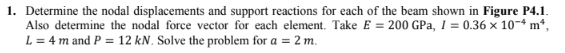

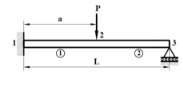

In [6]:
n_nodes = 3
area = [None, None]
modulus_elasticity = [200e09, 200e09]
moment_inertia = [0.36e-04, 0.36e-04]
material_stiffness = [None, None]
theta = [0, 0]
length = [2, 2]
elements = 2
element_connection = {1:[1,2], 2:[2,3]}
load_status = {2:[-12e03, 0]}
node_status = {1:[0,0], 2:[1,1], 3:[0,0] }

In [7]:
Q1 = Beam(elements=elements, modulus_elasticity=modulus_elasticity, moment_inertia = moment_inertia, length = length, area = area, material_stiffness= material_stiffness, element_connection = element_connection, nodes = n_nodes, theta = theta, node_status=node_status, load_status = load_status)


In [8]:
glob = assignment_answer(Q1)

Local Stiffness Matrix
[[ 10800000.  10800000. -10800000.  10800000.]
 [ 10800000.  14400000. -10800000.   7200000.]
 [-10800000. -10800000.  10800000. -10800000.]
 [ 10800000.   7200000. -10800000.  14400000.]]
[[ 10800000.  10800000. -10800000.  10800000.]
 [ 10800000.  14400000. -10800000.   7200000.]
 [-10800000. -10800000.  10800000. -10800000.]
 [ 10800000.   7200000. -10800000.  14400000.]]
Global Stiffness Matrix
[[ 10800000.  10800000. -10800000.  10800000.         0.         0.]
 [ 10800000.  14400000. -10800000.   7200000.         0.         0.]
 [-10800000. -10800000.  21600000.         0. -10800000.  10800000.]
 [ 10800000.   7200000.         0.  28800000. -10800000.   7200000.]
 [        0.         0. -10800000. -10800000.  10800000. -10800000.]
 [        0.         0.  10800000.   7200000. -10800000.  14400000.]]
Load Vector
[[     0.]
 [     0.]
 [-12000.]
 [     0.]
 [     0.]
 [     0.]]
Displacement Vector
[[ 0.        ]
 [ 0.        ]
 [-0.00055556]
 [ 0.        ]
 

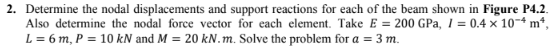

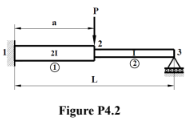

In [5]:
n_nodes = 3
area = [None, None]
modulus_elasticity = [200e09, 200e09]
moment_inertia = [2 * 0.4e-04, 0.4e-04]
material_stiffness = [None, None]
theta = [0, 0]
length = [3, 3]
elements = 2
element_connection = {1:[1,2], 2:[2,3]}
load_status = {2:[-10e03, 20e03]}
node_status = {1:[0,0], 2:[1,1], 3:[0,1] }

In [6]:
Q2 = Beam(elements=elements, modulus_elasticity=modulus_elasticity, moment_inertia = moment_inertia, length = length, area = area, material_stiffness= material_stiffness, element_connection = element_connection, nodes = n_nodes, theta = theta, node_status=node_status, load_status = load_status)

In [7]:
glob = assignment_answer(Q2)

Local Stiffness Matrix
[[  7111111.11111111  10666666.66666667  -7111111.11111111
   10666666.66666667]
 [ 10666666.66666667  21333333.33333334 -10666666.66666667
   10666666.66666667]
 [ -7111111.11111111 -10666666.66666667   7111111.11111111
  -10666666.66666667]
 [ 10666666.66666667  10666666.66666667 -10666666.66666667
   21333333.33333334]]
[[ 3555555.55555556  5333333.33333333 -3555555.55555556  5333333.33333333]
 [ 5333333.33333333 10666666.66666667 -5333333.33333333  5333333.33333333]
 [-3555555.55555556 -5333333.33333333  3555555.55555556 -5333333.33333333]
 [ 5333333.33333333  5333333.33333333 -5333333.33333333 10666666.66666667]]
Global Stiffness Matrix
[[  7111111.11111111  10666666.66666667  -7111111.11111111
   10666666.66666667         0.                 0.        ]
 [ 10666666.66666667  21333333.33333334 -10666666.66666667
   10666666.66666667         0.                 0.        ]
 [ -7111111.11111111 -10666666.66666667  10666666.66666667
   -5333333.33333333  -3555555

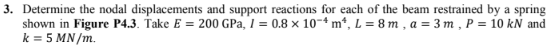

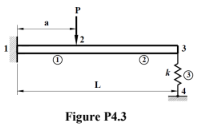

In [12]:
n_nodes = 4
area = [None, None, None]
modulus_elasticity = [200e09, 200e09, None]
moment_inertia = [0.8e-04, 0.8e-04, None]
material_stiffness = [None, None, 5e06]
theta = [0, 0, -90]
length = [3, 5, None]
elements = 3
element_connection = {1:[1,2], 2:[2,3], 3:[3,4]}
load_status = {2:[-10e03, 0]}
node_status = {1:[0,0], 2:[1,1], 3:[1,1], 4:[0,0] }

In [13]:
Q3 = Beam(elements=elements, modulus_elasticity=modulus_elasticity, moment_inertia = moment_inertia, length = length, area = area, material_stiffness= material_stiffness, element_connection = element_connection, nodes = n_nodes, theta = theta, node_status=node_status, load_status = load_status)

In [14]:
glob = assignment_answer(Q3)

Local Stiffness Matrix
[[  7111111.11111111  10666666.66666667  -7111111.11111111
   10666666.66666667]
 [ 10666666.66666667  21333333.33333334 -10666666.66666667
   10666666.66666667]
 [ -7111111.11111111 -10666666.66666667   7111111.11111111
  -10666666.66666667]
 [ 10666666.66666667  10666666.66666667 -10666666.66666667
   21333333.33333334]]
[[ 1536000.  3840000. -1536000.  3840000.]
 [ 3840000. 12800000. -3840000.  6400000.]
 [-1536000. -3840000.  1536000. -3840000.]
 [ 3840000.  6400000. -3840000. 12800000.]]
[[ 5000000.        0. -5000000.        0.]
 [       0.        0.        0.        0.]
 [-5000000.        0.  5000000.        0.]
 [       0.        0.        0.        0.]]
Global Stiffness Matrix
[[  7111111.11111111  10666666.66666667  -7111111.11111111
   10666666.66666667         0.                 0.
          0.                 0.        ]
 [ 10666666.66666667  21333333.33333334 -10666666.66666667
   10666666.66666667         0.                 0.
          0.         

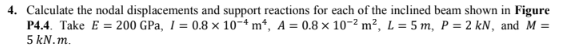

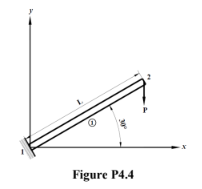

In [135]:
n_nodes = 2
area = [0.8e-02]
modulus_elasticity = [200e09]
moment_inertia = [0.8e-04]
material_stiffness = [None] 
theta = [30]
length = [5]   
elements = 1
element_connection = {1:[1,2]}    
load_status = {2:[0, -2e03, 5e03]}
node_status = {1:[0,0, 0], 2:[1, 1, 1]}

In [136]:
Q4 = Beam(elements=elements, modulus_elasticity=modulus_elasticity, moment_inertia = moment_inertia, length = length, area = area, material_stiffness= material_stiffness, element_connection = element_connection, nodes = n_nodes, theta = theta, node_status=node_status, load_status = load_status)

In [137]:
glob = assignment_answer(Q4)

Local Stiffness Matrix
[[ 2.40386547e+08  1.37899689e+08 -1.92000000e+06 -2.40386547e+08
  -1.37899689e+08 -1.92000000e+06]
 [ 1.37899689e+08  8.11520122e+07  3.32555520e+06 -1.37899689e+08
  -8.11520122e+07  3.32555520e+06]
 [-1.92000000e+06  3.32555520e+06  1.28000000e+07  1.92000000e+06
  -3.32555520e+06  6.40000000e+06]
 [-2.40386547e+08 -1.37899689e+08  1.92000000e+06  2.40386547e+08
   1.37899689e+08  1.92000000e+06]
 [-1.37899689e+08 -8.11520122e+07 -3.32555520e+06  1.37899689e+08
   8.11520122e+07 -3.32555520e+06]
 [-1.92000000e+06  3.32555520e+06  6.40000000e+06  1.92000000e+06
  -3.32555520e+06  1.28000000e+07]]
Global Stiffness Matrix
[[ 2.40386547e+08  1.37899689e+08 -1.92000000e+06 -2.40386547e+08
  -1.37899689e+08 -1.92000000e+06]
 [ 1.37899689e+08  8.11520122e+07  3.32555520e+06 -1.37899689e+08
  -8.11520122e+07  3.32555520e+06]
 [-1.92000000e+06  3.32555520e+06  1.28000000e+07  1.92000000e+06
  -3.32555520e+06  6.40000000e+06]
 [-2.40386547e+08 -1.37899689e+08  1.920000

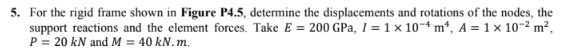

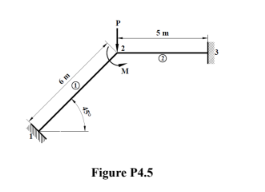

In [23]:
n_nodes = 3
area = [1e-02, 1e-02]
modulus_elasticity = [200e09, 200e09]
moment_inertia = [1e-04, 1e-04]
material_stiffness = [None, None]
theta = [45, 0]
length = [6, 5]
elements = 2
element_connection = {1:[1,2], 2:[2,3]}
load_status = {2:[0,-20e03, 40e03]}
node_status = {1:[0,0,0], 2:[1,1,1], 3:[0,0,0] }

In [24]:
Q5 = Beam(elements=elements, modulus_elasticity=modulus_elasticity, moment_inertia = moment_inertia, length = length, area = area, material_stiffness= material_stiffness, element_connection = element_connection, nodes = n_nodes, theta = theta, node_status=node_status, load_status = load_status)

In [25]:
glob = assignment_answer(Q5)

Local Stiffness Matrix
[[ 1.67222222e+08 -1.66111111e+08  2.35702260e+06 -1.67222222e+08
   1.66111111e+08  2.35702260e+06]
 [-1.66111111e+08  1.67222222e+08  2.35702260e+06  1.66111111e+08
  -1.67222222e+08  2.35702260e+06]
 [ 2.35702260e+06  2.35702260e+06  1.33333333e+07 -2.35702260e+06
  -2.35702260e+06  6.66666667e+06]
 [-1.67222222e+08  1.66111111e+08 -2.35702260e+06  1.67222222e+08
  -1.66111111e+08 -2.35702260e+06]
 [ 1.66111111e+08 -1.67222222e+08 -2.35702260e+06 -1.66111111e+08
   1.67222222e+08 -2.35702260e+06]
 [ 2.35702260e+06  2.35702260e+06  6.66666667e+06 -2.35702260e+06
  -2.35702260e+06  1.33333333e+07]]
[[ 4.00e+08  0.00e+00  0.00e+00 -4.00e+08  0.00e+00  0.00e+00]
 [ 0.00e+00  1.92e+06  4.80e+06  0.00e+00 -1.92e+06  4.80e+06]
 [ 0.00e+00  4.80e+06  1.60e+07  0.00e+00 -4.80e+06  8.00e+06]
 [-4.00e+08  0.00e+00  0.00e+00  4.00e+08  0.00e+00  0.00e+00]
 [ 0.00e+00 -1.92e+06 -4.80e+06  0.00e+00  1.92e+06 -4.80e+06]
 [ 0.00e+00  4.80e+06  8.00e+06  0.00e+00 -4.80e+06  1.

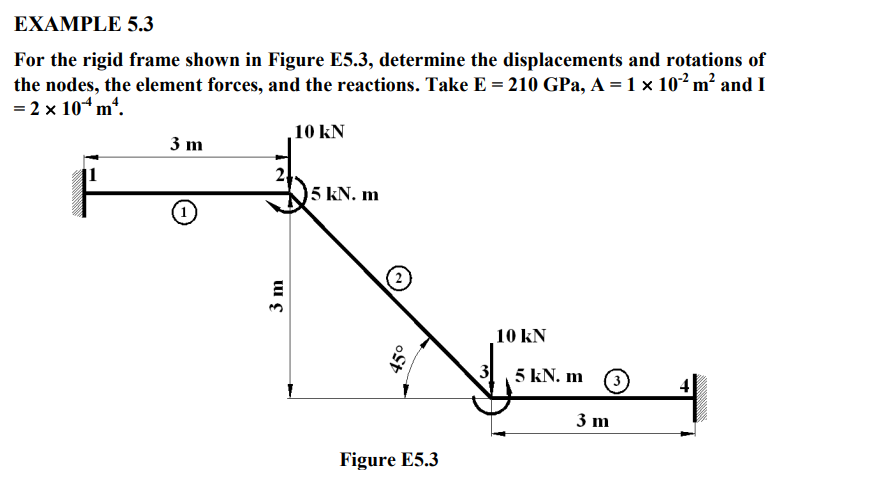

In [69]:
n_nodes = 4
area = [1e-02, 1e-02, 1e-02]
modulus_elasticity = [210e09, 210e09, 210e09]
moment_inertia = [2e-04, 2e-04, 2e-04]
material_stiffness = [None, None, None] 
theta = [0, -45, 0]
length = [3, 4.2464, 3]   
elements = 3
element_connection = {1:[1,2], 2:[2,3], 3:[3,4]}    
load_status = {2:[0, -10e03, -5e03], 3:[0, -10e03, 5e03]}
node_status = {1:[0, 0, 0], 2:[1, 1, 1], 3:[1, 1, 1], 4:[0, 0, 0]}

In [70]:
EXAMPLE_5_3 = Beam(elements=elements, modulus_elasticity=modulus_elasticity, moment_inertia = moment_inertia, length = length, area = area, material_stiffness= material_stiffness, element_connection = element_connection, nodes = n_nodes, theta = theta, node_status=node_status, load_status = load_status)

In [74]:
glob = assignment_answer(EXAMPLE_5_3)

Local Stiffness Matrix
[[ 7.00000000e+08  0.00000000e+00  0.00000000e+00 -7.00000000e+08
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.86666667e+07  2.80000000e+07  0.00000000e+00
  -1.86666667e+07  2.80000000e+07]
 [ 0.00000000e+00  2.80000000e+07  5.60000000e+07  0.00000000e+00
  -2.80000000e+07  2.80000000e+07]
 [-7.00000000e+08  0.00000000e+00  0.00000000e+00  7.00000000e+08
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.86666667e+07 -2.80000000e+07  0.00000000e+00
   1.86666667e+07 -2.80000000e+07]
 [ 0.00000000e+00  2.80000000e+07  2.80000000e+07  0.00000000e+00
  -2.80000000e+07  5.60000000e+07]]
[[ 2.50559350e+08 -2.43977199e+08  9.88197477e+06 -2.50559350e+08
   2.43977199e+08  9.88197477e+06]
 [-2.43977199e+08  2.50559350e+08  9.88197477e+06  2.43977199e+08
  -2.50559350e+08  9.88197477e+06]
 [ 9.88197477e+06  9.88197477e+06  3.95629239e+07 -9.88197477e+06
  -9.88197477e+06  1.97814619e+07]
 [-2.50559350e+08  2.43977199e+08 -9.88197477e+06  2.50559350e+08
 

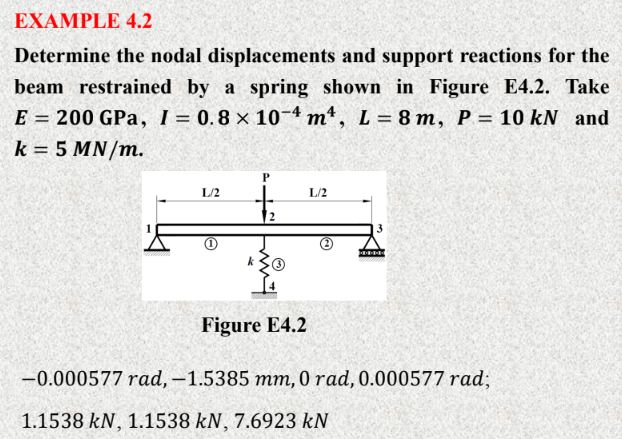

In [39]:
n_nodes = 4
area = [None, None, None, None]
modulus_elasticity = [200e09, 200e09, None]   
moment_inertia = [0.8e-04, 0.8e-04, None]
material_stiffness = [None, None, 5e06] 
theta = [0, 0, -90]
length = [4, 4, None]   
elements = 3
element_connection = {1:[1, 2], 2:[2, 3], 3:[2, 4]}    
load_status = {2:[-100e03, 0]}
node_status = {1:[ 0, 1], 2:[ 1, 1], 3:[ 0, 1], 4:[ 0, 0]}

In [40]:
EXAMPLE_4_2 = Beam(elements=elements, modulus_elasticity=modulus_elasticity, moment_inertia = moment_inertia, length = length, area = area, material_stiffness= material_stiffness, element_connection = element_connection, nodes = n_nodes, theta = theta, node_status=node_status, load_status = load_status)

In [42]:
glob = assignment_answer(EXAMPLE_4_2)

Local Stiffness Matrix
[[ 3000000.  6000000. -3000000.  6000000.]
 [ 6000000. 16000000. -6000000.  8000000.]
 [-3000000. -6000000.  3000000. -6000000.]
 [ 6000000.  8000000. -6000000. 16000000.]]
[[ 3000000.  6000000. -3000000.  6000000.]
 [ 6000000. 16000000. -6000000.  8000000.]
 [-3000000. -6000000.  3000000. -6000000.]
 [ 6000000.  8000000. -6000000. 16000000.]]
[[ 5000000.        0. -5000000.        0.]
 [       0.        0.        0.        0.]
 [-5000000.        0.  5000000.        0.]
 [       0.        0.        0.        0.]]
Global Stiffness Matrix
[[ 3000000.  6000000. -3000000.  6000000.        0.        0.        0.
         0.]
 [ 6000000. 16000000. -6000000.  8000000.        0.        0.        0.
         0.]
 [-3000000. -6000000. 11000000.        0. -3000000.  6000000. -5000000.
         0.]
 [ 6000000.  8000000.        0. 32000000. -6000000.  8000000.        0.
         0.]
 [       0.        0. -3000000. -6000000.  3000000. -6000000.        0.
         0.]
 [       

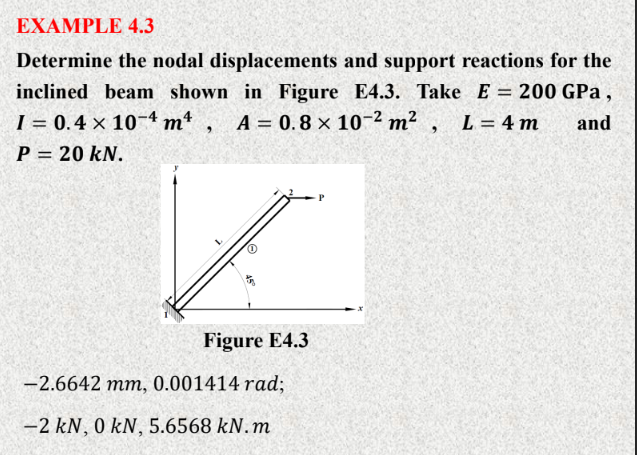

In [124]:
n_nodes = 2
area = [0.8e-02]
modulus_elasticity = [200e09]
moment_inertia = [0.4e-04]
material_stiffness = [None, None] 
theta = [45]
length = [4]   
elements = 1
element_connection = {1:[1, 2]}    
load_status = {2:[20e03, 0, 0]}
node_status = {1:[0, 0, 0], 2:[1, 1, 1]}

In [125]:
EXAMPLE_4_3 = Beam(elements=elements, modulus_elasticity=modulus_elasticity, moment_inertia = moment_inertia, length = length, area = area, material_stiffness= material_stiffness, element_connection = element_connection, nodes = n_nodes, theta = theta, node_status=node_status, load_status = load_status)

In [126]:
glob = assignment_answer(EXAMPLE_4_3)

C: 0.70711
S: 0.70711
Local Stiffness Matrix
[[ 2.00751828e+08  1.99251814e+08 -2.12133000e+06 -2.00751828e+08
  -1.99251814e+08 -2.12133000e+06]
 [ 1.99251814e+08  2.00751828e+08  2.12133000e+06 -1.99251814e+08
  -2.00751828e+08  2.12133000e+06]
 [-2.12133000e+06  2.12133000e+06  8.00000000e+06  2.12133000e+06
  -2.12133000e+06  4.00000000e+06]
 [-2.00751828e+08 -1.99251814e+08  2.12133000e+06  2.00751828e+08
   1.99251814e+08  2.12133000e+06]
 [-1.99251814e+08 -2.00751828e+08 -2.12133000e+06  1.99251814e+08
   2.00751828e+08 -2.12133000e+06]
 [-2.12133000e+06  2.12133000e+06  4.00000000e+06  2.12133000e+06
  -2.12133000e+06  8.00000000e+06]]
Global Stiffness Matrix
[[ 2.00751828e+08  1.99251814e+08 -2.12133000e+06 -2.00751828e+08
  -1.99251814e+08 -2.12133000e+06]
 [ 1.99251814e+08  2.00751828e+08  2.12133000e+06 -1.99251814e+08
  -2.00751828e+08  2.12133000e+06]
 [-2.12133000e+06  2.12133000e+06  8.00000000e+06  2.12133000e+06
  -2.12133000e+06  4.00000000e+06]
 [-2.00751828e+08 -1.

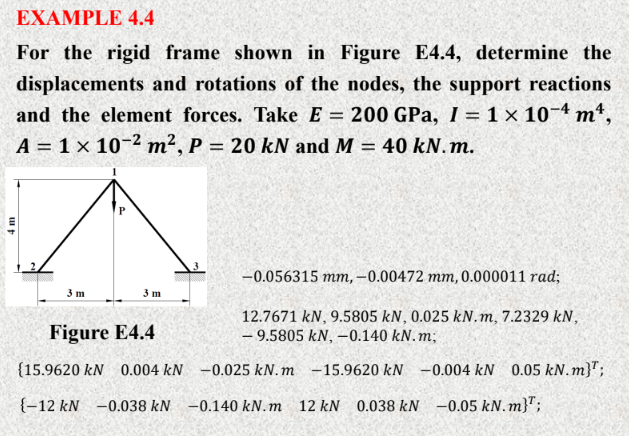

In [78]:
n_nodes = 3
area = [1e-02, 1e-02]
modulus_elasticity = [200e09, 200e09]
moment_inertia = [1e-04, 1e-04]
material_stiffness = [None, None] 
theta = [53.13, -53.13]
length = [5, 5]   
elements = 2
element_connection = {1:[1, 2], 2:[2,3]}    
load_status = {2:[0, -20e03, 40e03]}
node_status = {1:[0, 0, 0], 2:[1, 1, 1], 3:[0, 0, 0]}

In [79]:
EXAMPLE_4_4 = Beam(elements=elements, modulus_elasticity=modulus_elasticity, moment_inertia = moment_inertia, length = length, area = area, material_stiffness= material_stiffness, element_connection = element_connection, nodes = n_nodes, theta = theta, node_status=node_status, load_status = load_status)

In [80]:
GLOB = assignment_answer(EXAMPLE_4_4)

Local Stiffness Matrix
[[ 1.45229483e+08  1.91078599e+08 -3.83999486e+06 -1.45229483e+08
  -1.91078599e+08 -3.83999486e+06]
 [ 1.91078599e+08  2.56690517e+08  2.88000686e+06 -1.91078599e+08
  -2.56690517e+08  2.88000686e+06]
 [-3.83999486e+06  2.88000686e+06  1.60000000e+07  3.83999486e+06
  -2.88000686e+06  8.00000000e+06]
 [-1.45229483e+08 -1.91078599e+08  3.83999486e+06  1.45229483e+08
   1.91078599e+08  3.83999486e+06]
 [-1.91078599e+08 -2.56690517e+08 -2.88000686e+06  1.91078599e+08
   2.56690517e+08 -2.88000686e+06]
 [-3.83999486e+06  2.88000686e+06  8.00000000e+06  3.83999486e+06
  -2.88000686e+06  1.60000000e+07]]
[[ 1.45229483e+08 -1.91078599e+08  3.83999486e+06 -1.45229483e+08
   1.91078599e+08  3.83999486e+06]
 [-1.91078599e+08  2.56690517e+08  2.88000686e+06  1.91078599e+08
  -2.56690517e+08  2.88000686e+06]
 [ 3.83999486e+06  2.88000686e+06  1.60000000e+07 -3.83999486e+06
  -2.88000686e+06  8.00000000e+06]
 [-1.45229483e+08  1.91078599e+08 -3.83999486e+06  1.45229483e+08
 

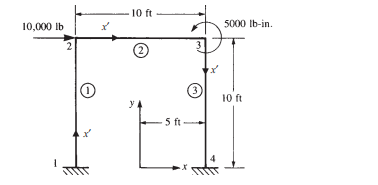

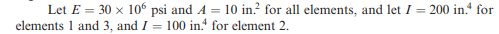

In [120]:
n_nodes = 4
area = [10, 10, 10]
modulus_elasticity = [30e06, 30e06, 30e06]
moment_inertia = [200, 100, 200]
material_stiffness = [None, None, None]
theta = [90, 0, -90]
length = [120, 120, 120]
elements = 3
element_connection = {1:[1,2], 2:[2,3], 3:[3,4]}
load_status = {2:[10e03, 0, 0], 3:[0, 0, 5e03]}
node_status = {1:[0, 0, 0], 2:[1, 1, 1], 3:[1, 1, 1], 4:[0, 0, 0]}

In [121]:
LOGAN_5_1 = Beam(elements=elements, modulus_elasticity=modulus_elasticity, moment_inertia = moment_inertia, length = length, area = area, material_stiffness= material_stiffness, element_connection = element_connection, nodes = n_nodes, theta = theta, node_status=node_status, load_status = load_status)

In [122]:
glob = assignment_answer(LOGAN_5_1)

C: 0.0
S: 1.0
C: 1.0
S: 0.0
C: 0.0
S: -1.0
Local Stiffness Matrix
[[ 4.16666667e+04  0.00000000e+00 -2.50000000e+06 -4.16666667e+04
   0.00000000e+00 -2.50000000e+06]
 [ 0.00000000e+00  2.50000000e+06  0.00000000e+00  0.00000000e+00
  -2.50000000e+06  0.00000000e+00]
 [-2.50000000e+06  0.00000000e+00  2.00000000e+08  2.50000000e+06
   0.00000000e+00  1.00000000e+08]
 [-4.16666667e+04  0.00000000e+00  2.50000000e+06  4.16666667e+04
   0.00000000e+00  2.50000000e+06]
 [ 0.00000000e+00 -2.50000000e+06  0.00000000e+00  0.00000000e+00
   2.50000000e+06  0.00000000e+00]
 [-2.50000000e+06  0.00000000e+00  1.00000000e+08  2.50000000e+06
   0.00000000e+00  2.00000000e+08]]
[[ 2.50000000e+06  0.00000000e+00  0.00000000e+00 -2.50000000e+06
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.08333333e+04  1.25000000e+06  0.00000000e+00
  -2.08333333e+04  1.25000000e+06]
 [ 0.00000000e+00  1.25000000e+06  1.00000000e+08  0.00000000e+00
  -1.25000000e+06  5.00000000e+07]
 [-2.50000000e+06  0.000

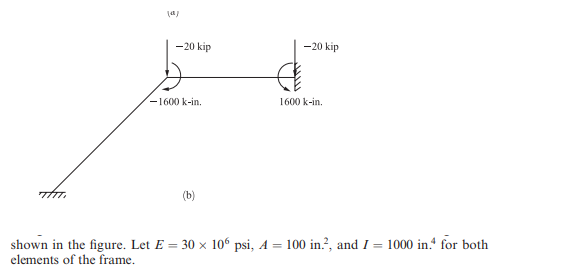

In [123]:
n_nodes = 3
area = [100, 100]
modulus_elasticity = [30e06, 30e06]
moment_inertia = [1000, 1000]
material_stiffness = [None, None]
theta = [45, 0]
length = [509, 480]
elements = 2
element_connection = {1:[1,2], 2:[2,3]}
load_status = {2:[0, -20, -1600]} #, 3:[0, -20e03, 1600]}
node_status = {1:[0, 0, 0], 2:[1, 1, 1], 3:[0, 0, 0]}

In [48]:
LOGAN_5_2 = Beam(elements=elements, modulus_elasticity=modulus_elasticity, moment_inertia = moment_inertia, length = length, area = area, material_stiffness= material_stiffness, element_connection = element_connection, nodes = n_nodes, theta = theta, node_status=node_status, load_status = load_status)

In [49]:
GLOB = assignment_answer(LOGAN_5_2)

Local Stiffness Matrix
[[ 2.94831977e+06  2.94558986e+06 -4.91271921e+05 -2.94831977e+06
  -2.94558986e+06 -4.91271921e+05]
 [ 2.94558986e+06  2.94831977e+06  4.91271921e+05 -2.94558986e+06
  -2.94831977e+06  4.91271921e+05]
 [-4.91271921e+05  4.91271921e+05  2.35756385e+08  4.91271921e+05
  -4.91271921e+05  1.17878193e+08]
 [-2.94831977e+06 -2.94558986e+06  4.91271921e+05  2.94831977e+06
   2.94558986e+06  4.91271921e+05]
 [-2.94558986e+06 -2.94831977e+06 -4.91271921e+05  2.94558986e+06
   2.94831977e+06 -4.91271921e+05]
 [-4.91271921e+05  4.91271921e+05  1.17878193e+08  4.91271921e+05
  -4.91271921e+05  2.35756385e+08]]
[[ 6.25000000e+06  0.00000000e+00  0.00000000e+00 -6.25000000e+06
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.25520833e+03  7.81250000e+05  0.00000000e+00
  -3.25520833e+03  7.81250000e+05]
 [ 0.00000000e+00  7.81250000e+05  2.50000000e+08  0.00000000e+00
  -7.81250000e+05  1.25000000e+08]
 [-6.25000000e+06  0.00000000e+00  0.00000000e+00  6.25000000e+06
 